In [6]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
import datetime
import time
import os
import re

from IPython.display import clear_output

# 기본 설정
binance = ccxt.binance(config={
    'options': {"defaultType" : "future"}
})

### 데이터 다운 및 업데이트 하기
def Save_and_Update_Data(coin, save_path):
    file_name = coin.replace("/USDT","_M") # 이름 수정
    
    if os.path.exists(os.path.join(save_path, f"{file_name}.xlsx"))==True: # 파일이 존재할 경우
        df = pd.read_excel(os.path.join(save_path,f"{file_name}.xlsx"),index_col=0)
        past = datetime.datetime.strptime(str(df.iloc[-1].name), f'%Y-%m-%d %H:%M:00')
        now = datetime.datetime.now().strftime(f'%Y-%m-%d %H:%M:00')
        now = datetime.datetime.strptime(now, f'%Y-%m-%d %H:%M:00')
        diff = str(now-past)
        h, m, s = list(map(int, diff.split(":")))
        total_time_diff = (h * 60) + m + s # 분으로 환산
        total_time_diff

        if total_time_diff > 0: # 1분 이상 차이 날 경우
            new_ohlcv = binance.fetch_ohlcv(
                f'{coin}', 
                timeframe='1m',
                params={"startTime":df.index[-1]},
                limit=total_time_diff
            )
            new_df = pd.DataFrame(new_ohlcv, columns=['datetime','open','high','low','close','volume'])
            Cal_DataFrame(new_df) # OHCLV 값 기반으로 계산
            new_df['datetime'] = pd.to_datetime(new_df['datetime'], unit='ms') + datetime.timedelta(hours=9)
            new_df.set_index('datetime',inplace=True)
            df = pd.concat([df,new_df])
            print(f"[{coin}] Update {total_time_diff} minutes")
        else: # 1분 이하로 초단위로 차이 날 경우, 맨 마지막 행 업데이트
            new_ohlcv = binance.fetch_ohlcv(f'{coin}', timeframe='1m',limit=1)
            new_df = pd.DataFrame(new_ohlcv, columns=['datetime','open','high','low','close','volume'])
            Cal_DataFrame(new_df) # OHCLV 값 기반으로 계산
            new_df['datetime'] = pd.to_datetime(new_df['datetime'], unit='ms') + datetime.timedelta(hours=9)
            new_df.set_index('datetime',inplace=True)
            df = pd.concat([df[:-1],new_df])
#             print(f"[{coin}] Update Under 1 minutes")
    else: # 파일이 존재하지 않을 경우
        ### Data가 없을 때 1500개 1분봉 데이터 다운
#         print(f"[{coin}] New Data Saving . . .")
        ohlcv = binance.fetch_ohlcv(f'{coin}', timeframe='1m',limit=1500)
        df = pd.DataFrame(ohlcv, columns=['datetime','open','high','low','close','volume'])
        Cal_DataFrame(df) # OHCLV 값 기반으로 계산
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms') + datetime.timedelta(hours=9)
        df.set_index('datetime',inplace=True)
        time.sleep(0.5)

    df = df.loc[~df.index.duplicated(keep='last')] #최신행만 남겨두고 중복된 행 제거
    df.to_excel(f'{os.path.join(save_path, file_name)}.xlsx') # 엑셀 데이터로 저장
    
    return df
    
def Cal_DataFrame(DataFrame): #[time, open, high, low, close, volume]
    df = DataFrame
    
    # 가중치를 둔 거래대금
    df['Cal_Value'] = (df['open']*0.20+df['high']*0.15+df['low']*0.15+df['close']*0.50)*df['volume']/1000000
     

    return df

def Up_Sampling(DataFrame, date): # 1분봉 데이터프레임, 날짜 입력
    df = DataFrame.copy()
    new_df = DataFrame.copy()
    new_df['open'] = df.resample(f'{date}').first()['open'] # 시가
    new_df['high'] = df.resample(f'{date}').max()['high'] # 고가
    new_df['low'] = df.resample(f'{date}').min()['low'] # 저가
    new_df['close'] = df.resample(f'{date}').last()['close'] # 종가
    new_df['volume'] = df.resample(f'{date}').sum()['volume'] # 거래량
    new_df['Cal_Value'] = df.resample(f'{date}').sum()['Cal_Value'] # 거래대금

    new_df = new_df.resample(f'{date}').first()
    return new_df

# 주문 거래 금액 비율, 시장 참여자들의 거래 비율, 거래한 비트코인 갯수 
def Trades_Summary():
    trades = binance.fetchTrades("BTCUSDT",limit=1000) #1000개의 BTCUSDT를 거래 내역 가져온다
    Value_dics = {}
    
    
    buy_sum = 0 # 매수 총금액
    sell_sum = 0 # 매도 총금액
    taker_num = 0 # 시장가 숫자
    maker_num = 0 # 지정가 숫자
    buy_coin_amount = 0 # buy한 비트코인
    sell_coin_amount = 0 # sell 한 비트코인
    
    for i in range(len(trades)):
        if trades[i]['side'] == "buy": #매수일 경우
            buy_sum += trades[i]['cost']
        elif trades[i]['side'] == "sell": # 매도일 경우
            sell_sum += trades[i]['cost']

        if trades[i]['info']['m'] == False: # 시장가일경우
            taker_num += 1
        elif trades[i]['info']['m'] == True: #지정가일경우
            maker_num +=1
            
        if trades[i]['side'] == "buy": #매수일 경우
            buy_coin_amount += trades[i]['amount']
        elif trades[i]['side'] == "sell": # 매도일 경우
            sell_coin_amount += trades[i]['amount']

    Value_dics['buy_sum'] = buy_sum
    Value_dics['sell_sum'] = sell_sum
    Value_dics['maker_num'] = maker_num
    Value_dics['taker_num'] = taker_num
    Value_dics['buy_coin_amount'] = buy_coin_amount
    Value_dics['sell_coin_amount'] = sell_coin_amount
    
    
    Value_dics['last_time'] = trades[-1]['timestamp']
    
    return Value_dics
    
    
    
        
def Values_Print(DataFrame, Total_Value_Dictionary):
    ### ---------------Data Preprocessing
    df_5 = Up_Sampling(DataFrame,'5T') # 1분봉을 5분봉으로 바꾸기
    
    clear_output() #이전 print글자 지워주기 (주피터 환경)
#     os.system('cls') # 윈도우 환경

    ### ---------------Summary Values
    buy_sum = Total_Value_Dictionary['buy_sum']
    sell_sum = Total_Value_Dictionary['sell_sum']
    maker_num = Total_Value_Dictionary['maker_num']
    taker_num = Total_Value_Dictionary['taker_num']
    buy_coin_amount = Total_Value_Dictionary['buy_coin_amount']
    sell_coin_amount = Total_Value_Dictionary['sell_coin_amount']

    print("=============================== Summary ================================")
    print(f"========================== {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} =========================\n")
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("[Buy Position]\t|\t[Sell Position]")
    print(f"{round((buy_sum/(buy_sum+sell_sum)),2)}\t\t|\t{round((sell_sum/(buy_sum+sell_sum)),2)}\t\t(Ratio of trade cost sum)")
    print(f"{round(buy_coin_amount,3)}\t\t|\t{round(sell_coin_amount,3)}\t\t(Bitcoin Total amount)")
    print(f"{round(buy_sum,3)}\t|\t{round(sell_sum,3)}\t(Bitcoin Total Cost)")
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -\n")
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
    print("[Maker]\t\t|\t[Taker]")
    print(f"{round((maker_num/(maker_num+taker_num)),2)}\t\t|\t{round((taker_num/(maker_num+taker_num)),2)}\t\t(Ratio of Participant)")
    print(f"{round(maker_num,3)}\t\t|\t{round(taker_num,3)}\t\t(Number of Participant)")
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -\n")
    print("")
    print(f"[Buy - Sell] Trade Cost : {round((buy_sum - sell_sum),2)}")

    print("")
    if round((sell_sum/(buy_sum+sell_sum)),2) < 0.3:
        print("Sell 금액 우세")
    elif round((buy_sum/(buy_sum+sell_sum)),2) > 0.7:
        print("Buy 금액 우세")

    
    ### --------------- OHLCV 출력
    if df_5.iloc[-1]['volume'] < df.iloc[-1]['volume']:
        print("거래량 급증 이전 5분보다 상승")
    if ((df['Cal_Value'][-2] + df['Cal_Value'][-3])/2*3) < df['Cal_Value'][-1]:
        print("거래대금 급증")
        print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    pass


def Drawing_Graph(DataFrame, Total_Value_Dictionary):
    global graph_x_line # x축 데이터
    global graph_y_line # y축 데이터 (b_ratio)
    global graph_y_2_line # y축 데이터 (maker_ratio)
    
    df = DataFrame
    
    buy_sum = Total_Value_Dictionary['buy_sum']
    sell_sum = Total_Value_Dictionary['sell_sum']
    maker_num = Total_Value_Dictionary['maker_num']
    taker_num = Total_Value_Dictionary['taker_num']
    
    last_time = Total_Value_Dictionary['last_time']/1000
    #----------------------------------------------------------------------------------#
    
    b_ratio = round((buy_sum/(buy_sum+sell_sum)),2)
    s_ration = round((sell_sum/(buy_sum+sell_sum)),2)
    maker_ratio = round((maker_num/(maker_num+taker_num)),2)
    taker_ratio = round((taker_num/(maker_num+taker_num)),2)
    
    
    #----------------------------------------------------------------------------------#
    # 그래프에 추가할 값을 리스트에 추가해주기
    # x축 데이터
    graph_x_line.append(last_time) 
    
    # y축 데이터
    graph_y_line.append(b_ratio) # buy ratio
    opposite_graph_y_line = list(map(lambda x: 1-x, graph_y_line)) # sell ratio
    graph_y_2_line.append(maker_ratio) # maker ratio
    opposite_graph_y_2_line = list(map(lambda x: 1-x, graph_y_2_line)) # taker ratio
    
    
    # ax 그래프에 그리기
    ax.plot(graph_x_line,graph_y_line,color='g', label='b_ratio')
#     ax.plot(graph_x_line,opposite_graph_y_line,color='b', label='s_ratio')
    ax.plot(graph_x_line,graph_y_2_line,color='r', label='maker_ratio')
    
    ax.axhline(0.7, color='lightgray', linestyle='--') # 0.7 이상이면 Buy 우세
    ax.axhline(0.3, color='lightgray', linestyle='--') # 0.3 이하이면 Sell 우세
    ax.axhline(0.5, color='gray', linestyle='solid', label='Same Balanced') # 0.3 이하이면 Sell 우세
    
    
    
    
    # top_axes 그래프 그리기
    little_df = df[-3:].copy()
    idx = little_df.index[:].astype('str')
    top_axes.plot(idx, little_df['close'], linewidth=0.1)
    candlestick2_ohlc(top_axes, little_df['open'], little_df['high'], 
                      little_df['low'], little_df['close'],
                      width=0.5, colorup='r', colordown='b')
    
    
    # 최종 그리기
    fig.canvas.draw()
    
    # 축 설정
    # 캔들 그래프 설정
    top_axes.set_title(f'BTC/USDT', fontsize=20)
    plt.setp(top_axes.get_xticklabels(), visible=False) # top_axes의 라벨 제거
    

    # Trades Summary 그래프 설정
    ax.set_xlim(left=max(0,last_time-50),right=last_time+50)
    ax.set_ylim([0,1])
    

<IPython.core.display.Javascript object>


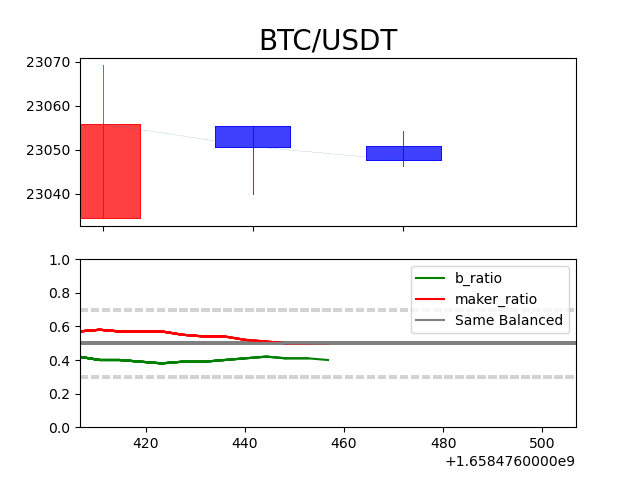

In [7]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

fig = plt.figure()
top_axes = fig.add_subplot(211)
ax = fig.add_subplot(212)

fig.show()

In [8]:
### 기본 설정
coin ='BTC/USDT'
path = os.path.join(os.getcwd(),"Save Data") # 데이터 저장 위치

### 그래프 설정
graph_x_line, graph_y_line, graph_y_2_line = [], [], []
legend_set = False

start_time = time.time()
print("*-------------Start-------------*")
while True:
    
    df = Save_and_Update_Data(coin,path) # 데이터 저장 및 업데이트
    
    summary_values = Trades_Summary() # 거래현형 요약본
    
    Values_Print(df, summary_values) # 값 print하여 출력하기
    Drawing_Graph(df, summary_values) # 그래프 그리기
    time.sleep(0.5)
    
    
    end_time = time.time()
    if legend_set ==False: # plt .legend 한번만 쓰기 위해서
        plt.legend()
        legend_set =True
    if (end_time - start_time) > 60*60: # 30분 뒤 종료
        break
    
    top_axes.cla() # 캔들 그래프 지워주기 (중복 그리기 방지하기 위해)
print("*--------------End--------------*")

=============================== Summary ================================
========================== 2022-07-22 16:54:17 =========================

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[Buy Position]	|	[Sell Position]
0.4		|	0.6		(Ratio of trade cost sum)
107.403		|	157.987		(Bitcoin Total amount)
2475278.233	|	3641053.608	(Bitcoin Total Cost)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[Maker]		|	[Taker]
0.5		|	0.5		(Ratio of Participant)
498		|	502		(Number of Participant)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


[Buy - Sell] Trade Cost : -1165775.38



C:\Users\HAIC\AppData\Local\Temp/ipykernel_24184/3446624256.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()


KeyboardInterrupt: 